# Neutral Atmosphere Lab

This lab will guide you through performing basic analysis and plotting of neutral atmosphere GNSS radio occultation (RO) data from CDAAC.

For this, we'll...

## Data selection

Let's first select the date we'll analyze. This will be done in the typical RO format of year.day_of_year. For example, 2023 May 01 is coded as '2023.121'. A day of year calendar, such as [this one hosted at NOAA ESRL](https://www.esrl.noaa.gov/gmd/grad/neubrew/Calendar.jsp?view=DOY&year=2023&col=4), can be helpful when working with this format.

In [1]:
# USER INPUT: Date selection
data_yrdoy = '2023.121'

The above date determines the data directories from which we will read occultation files. The below will use Python f-strings to fill the year.day_of_year variable `data_yrdoy` between curly brackets in the string declaration.

In [2]:
# Data directories for neutral atmosphere products
atmPrf_data_dir = f'./userdata/data/cosmic2/nrt/level2/atmPrf/{data_yrdoy}/'
wetPf2_data_dir = f'./userdata/data/cosmic2/nrt/level2/wetPf2/{data_yrdoy}/'

# Plot directory
plot_dir = './userdata/plots/'

# Information
print(f'[INFO] Data directory for atmPrf : {atmPrf_data_dir}')
print(f'[INFO] Data directory for wetPf2 : {wetPf2_data_dir}')
print(f'[INFO] Plot directory            : {plot_dir}')

[INFO] Data directory for atmPrf : ./userdata/data/cosmic2/nrt/level2/atmPrf/2023.121/
[INFO] Data directory for wetPf2 : ./userdata/data/cosmic2/nrt/level2/wetPf2/2023.121/
[INFO] Plot directory            : ./userdata/plots/


## Imports

In [3]:
# Libraries
import os
import requests
import tarfile
from datetime import datetime
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt

## Preparation

Note: this section may be skipped if the data are downloaded and extracted into the appropriate directories.

Using our examples from the previous days' labs, download the data files we'll use, if they don't already exist.

To start, we'll use Python functionality to create a data directory structure to hold our data and plots. TODO: Fill in more information about the structure.

In [4]:
# Create directories, if they don't already exist
os.makedirs(atmPrf_data_dir,exist_ok=True)
os.makedirs(wetPf2_data_dir,exist_ok=True)
os.makedirs(plot_dir,exist_ok=True)

Now check if the tar files exist. Download them if not. Check if the tar files have been untarred. Untar them if not. The below will use Python f-strings to fill the file name and server path variables using the date variables.

In [5]:
# Get the year and day-of-year separately
data_year, data_doy = data_yrdoy.split('.')

# Tar file names and paths
atmPrf_tar_fname = f'atmPrf_nrt_{data_year}_{data_doy}.tar.gz'
wetPf2_tar_fname = f'wetPf2_nrt_{data_year}_{data_doy}.tar.gz'
atmPrf_tar_path = f'./userdata/data/cosmic2/nrt/level2/atmPrf/{atmPrf_tar_fname}'
wetPf2_tar_path = f'./userdata/data/cosmic2/nrt/level2/wetPf2/{wetPf2_tar_fname}'

# Server path
cdaac_url = f'https://data.cosmic.ucar.edu/gnss-ro/cosmic2/nrt/level2/{data_year}/{data_doy}/'
atmPrf_tar_url = f'{cdaac_url}{atmPrf_tar_fname}'
wetPf2_tar_url = f'{cdaac_url}{wetPf2_tar_fname}'

# atmPrf tar file is downloaded?
if (not os.path.isfile(atmPrf_tar_path)):
    response = requests.get(atmPrf_tar_url, stream=True)
    if response.status_code == 200:
        with open(atmPrf_tar_path, 'wb') as fileid:
            fileid.write(response.raw.read())

# atmPrf is untarred?
if (len(os.listdir(atmPrf_data_dir)) == 0):
    with tarfile.open(atmPrf_tar_path) as fileid:
        fileid.extractall(atmPrf_data_dir)

# wetPf2 tar file is downloaded?
if (not os.path.isfile(wetPf2_tar_path)):
    response = requests.get(wetPf2_tar_url, stream=True)
    if response.status_code == 200:
        with open(wetPf2_tar_path, 'wb') as fileid:
            fileid.write(response.raw.read())

# wetPf2 is untarred?
if (len(os.listdir(wetPf2_data_dir)) == 0):
    with tarfile.open(wetPf2_tar_path) as fileid:
        fileid.extractall(wetPf2_data_dir)

## Single occultation analysis

This section will show how to generate simple plots of a single occultation. We will use these plots to further explore the contents of both of the primary neutral atmospheric products: atmPrf and wetPf2.

As a reminder, atmPrf contains the high-resolution occultation data, including bending angle and refractivity, and atmospheric fields calculated under the assumption of no water vapor. The wetPf2 product contains atmospheric fields retrieved through use of a one-dimensional variational analysis process. The below example analysis will illustrate the different resolutions and contents of both products.

First we will select a random occultation from the data directory, ensuring that it has been labelled "good" by the CDAAC quality controls. We will perform this check using both the atmPrf and wetPf2 products.

We will first count the number of profiles.

In [6]:
# Get the occultation file names and counts in our directories
atmPrf_fnames = os.listdir(atmPrf_data_dir)
wetPf2_fnames = os.listdir(wetPf2_data_dir)
n_atmPrf = len(atmPrf_fnames)
n_wetPf2 = len(wetPf2_fnames)

# Information
print(f'[INFO] Number of atmPrf files : {n_atmPrf}')
print(f'[INFO] Number of wetPf2 files : {n_wetPf2}')

[INFO] Number of atmPrf files : 4792
[INFO] Number of wetPf2 files : 4792


Now initialize the random number generator. For demonstration purposes, the random number generator will be initialized such that it always selects the same profile.

Select the random (or "random") profile index.

In [26]:
# Seeded (not random) random number generator
rng = np.random.default_rng(92842)

# Uncomment the below for random number generator
#rng = np.random.default_rng()

# Select a random integer up to the minimum of the two counts
max_prf_count = np.min([n_atmPrf,n_wetPf2])
prf_idx = rng.integers(low=0, \
                       high=max_prf_count,
                       size=1
                      )[0]

# Get the profile ID using the atmPrf data set
atmPrf_fname_short_now = atmPrf_fnames[prf_idx]
wetPf2_fname_short_now = atmPrf_fname_short_now.replace('atmPrf','wetPf2')
prf_id_now = atmPrf_fname_short_now.split('_')[1]

# Get the file names
atmPrf_fname_now = f'{atmPrf_data_dir}{atmPrf_fname_short_now}'
wetPf2_fname_now = f'{wetPf2_data_dir}{wetPf2_fname_short_now}'
atmPrf_fname_short_now = atmPrf_fname_now.split('/')[-1]
wetPf2_fname_short_now = wetPf2_fname_now.split('/')[-1]

# Information
print(f'[INFO] Selected index                   : {prf_idx}')
print(f'[INFO] Selected atmPrf file name        : {atmPrf_fname_short_now}')
print(f'[INFO] Selected wetPf2 file name        : {wetPf2_fname_short_now}')
print(f'[INFO] Selected atmPrf file name (full) : {atmPrf_fname_now}')
print(f'[INFO] Selected wetPf2 file name (full) : {wetPf2_fname_now}')
print(f'[INFO] Selected profile ID              : {prf_id_now}')

[INFO] Selected index                   : 150
[INFO] Selected atmPrf file name        : atmPrf_C2E2.2023.121.21.51.G23_0001.0001_nc
[INFO] Selected wetPf2 file name        : wetPf2_C2E2.2023.121.21.51.G23_0001.0001_nc
[INFO] Selected atmPrf file name (full) : ./userdata/data/cosmic2/nrt/level2/atmPrf/2023.121/atmPrf_C2E2.2023.121.21.51.G23_0001.0001_nc
[INFO] Selected wetPf2 file name (full) : ./userdata/data/cosmic2/nrt/level2/wetPf2/2023.121/wetPf2_C2E2.2023.121.21.51.G23_0001.0001_nc
[INFO] Selected profile ID              : C2E2.2023.121.21.51.G23


Read the files into memory. Check if they are flagged as "bad" or not. Profiles are flagged as "bad" if the global attribute "bad" is 1.

In [8]:
# Use netCDF4 to read the files
atmPrf_ncid_now = Dataset(atmPrf_fname_now)
wetPf2_ncid_now = Dataset(wetPf2_fname_now)

# Read bad flags from both files
atmPrf_bad_flag = int(atmPrf_ncid_now.bad)
wetPf2_bad_flag = int(wetPf2_ncid_now.bad)
atmPrf_bad_or_good = 'bad' if atmPrf_bad_flag else 'good'
wetPf2_bad_or_good = 'bad' if wetPf2_bad_flag else 'good'

# Information
print(f'[INFO] atmPrf file bad flag is "{atmPrf_bad_flag}"; the file is {atmPrf_bad_or_good.upper()}.')
print(f'[INFO] wetPf2 file bad flag is "{wetPf2_bad_flag}"; the file is {wetPf2_bad_or_good.upper()}.')

[INFO] atmPrf file bad flag is "0"; the file is GOOD.
[INFO] wetPf2 file bad flag is "0"; the file is GOOD.


For the demonstration, the random number generator has been seeded such that the occultation we select is "good" in both files. If the random number generator was not seeded in this way -- say by using the commented command for `rng` above -- then the below will iteratively check the files until a "good" occultation is selected.

In [28]:
n_rnd_idx_now = 1
while ( (atmPrf_bad_flag | wetPf2_bad_flag) 
       & (n_rnd_idx_now < max_prf_count) ):
    # Get a new random index
    prf_idx = rng.integers(low=0, \
                           high=max_prf_count,
                           size=1
                          )[0]
    # Get the profile ID using the atmPrf data set
    atmPrf_fname_short_now = atmPrf_fnames[prf_idx]
    wetPf2_fname_short_now = atmPrf_fname_short_now.replace('atmPrf','wetPf2')
    prf_id_now = atmPrf_fname_short_now.split('_')[1]
    
    # Get the file names
    atmPrf_fname_now = f'{atmPrf_data_dir}{atmPrf_fname_short_now}'
    wetPf2_fname_now = f'{wetPf2_data_dir}{wetPf2_fname_short_now}'
    atmPrf_fname_short_now = atmPrf_fname_now.split('/')[-1]
    wetPf2_fname_short_now = wetPf2_fname_now.split('/')[-1]
    
    # Close older files
    atmPrf_ncid_now.close()
    wetPf2_ncid_now.close()
    
    # Use netCDF4 to read the new files
    atmPrf_ncid_now = Dataset(atmPrf_fname_now)
    wetPf2_ncid_now = Dataset(wetPf2_fname_now)
    
    # Read bad flags from both files
    atmPrf_bad_flag = int(atmPrf_ncid_now.bad)
    wetPf2_bad_flag = int(wetPf2_ncid_now.bad)
    atmPrf_bad_or_good = 'bad' if atmPrf_bad_flag else 'good'
    wetPf2_bad_or_good = 'bad' if wetPf2_bad_flag else 'good'

    # Iterate
    n_rnd_idx_now += 1

# Information
print(f'[INFO] Selected index                   : {prf_idx}')
print(f'[INFO] Selected atmPrf file name        : {atmPrf_fname_short_now}')
print(f'[INFO] Selected wetPf2 file name        : {wetPf2_fname_short_now}')
print(f'[INFO] Selected atmPrf file name (full) : {atmPrf_fname_now}')
print(f'[INFO] Selected wetPf2 file name (full) : {wetPf2_fname_now}')
print(f'[INFO] Selected profile ID              : {prf_id_now}')
print(f'[INFO] atmPrf file bad flag is "{atmPrf_bad_flag}"; the file is {atmPrf_bad_or_good.upper()}.')
print(f'[INFO] wetPf2 file bad flag is "{wetPf2_bad_flag}"; the file is {wetPf2_bad_or_good.upper()}.')

[INFO] Selected index                   : 150
[INFO] Selected atmPrf file name        : atmPrf_C2E2.2023.121.21.51.G23_0001.0001_nc
[INFO] Selected wetPf2 file name        : wetPf2_C2E2.2023.121.21.51.G23_0001.0001_nc
[INFO] Selected atmPrf file name (full) : ./userdata/data/cosmic2/nrt/level2/atmPrf/2023.121/atmPrf_C2E2.2023.121.21.51.G23_0001.0001_nc
[INFO] Selected wetPf2 file name (full) : ./userdata/data/cosmic2/nrt/level2/wetPf2/2023.121/wetPf2_C2E2.2023.121.21.51.G23_0001.0001_nc
[INFO] Selected profile ID              : C2E2.2023.121.21.51.G23
[INFO] atmPrf file bad flag is "0"; the file is GOOD.
[INFO] wetPf2 file bad flag is "0"; the file is GOOD.


### atmPrf

At CDAAC, the so-caled atmPrf data set contains high-resolution profiles of neutral atmospheric variables *which do not explicitly consider moisture*. This includes bending angle, refractivity, "dry pressure," and "dry temperature", as well as positioning variables such as mean sea-level height, impact height, latitude, and longitude. Dry pressure and temperature are derived from refractivity assuming the atmosphere has no water vapor.

Let's investigate some of the variables of our selected atmPrf profile through plots of the fields.

Firstly, we'll extract the data into numpy arrays, and find out how many levels are in this profile.

In [21]:
# Extract the data from the netCDF
bending_angle = atmPrf_ncid_now.variables['Bend_ang'][:] * 1.E6 # Convert to units [microradians]
refractivity = atmPrf_ncid_now.variables['Ref'][:] # Units [N-units]
mean_sea_level_height = atmPrf_ncid_now.variables['MSL_alt'][:] # Units [km]

# Basic analysis of variable size
n_levs = mean_sea_level_height.size

# Information
print(f'[INFO] Number of levels : {n_levs}')

[INFO] Number of levels : 3885


Next, generate plots of bending angle and refractivity versus mean sea-level height.

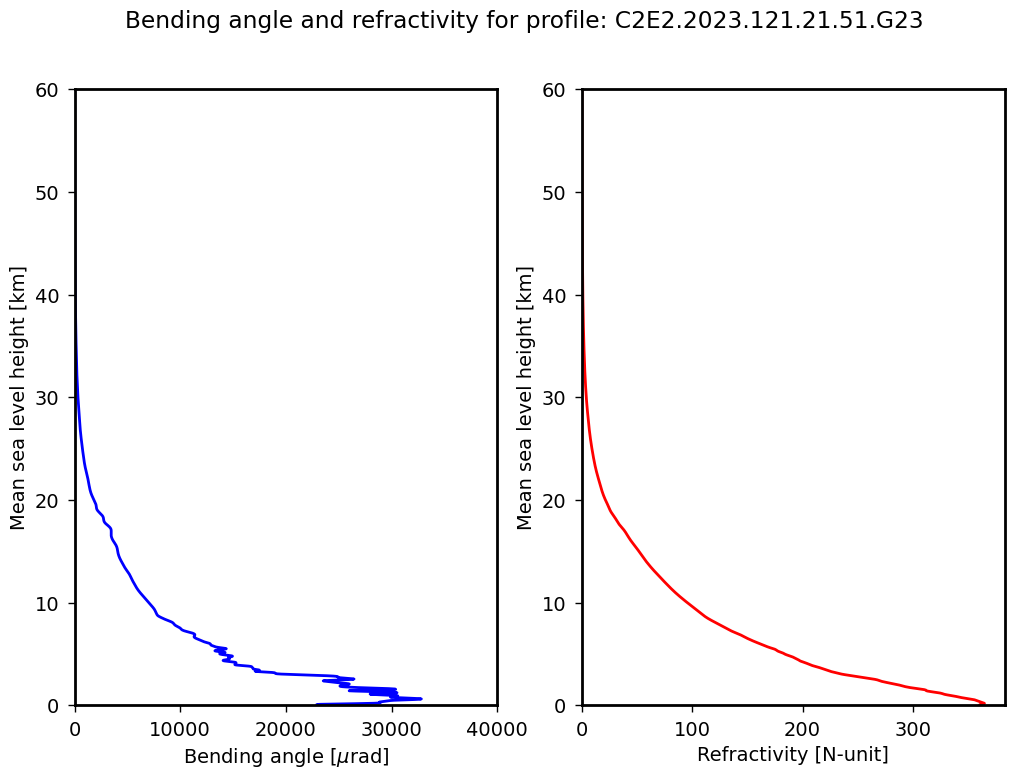

In [23]:
"""
Plot bending angle versus mean sea-level height
"""
# Create the figure object with two columns and one row
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,6))
# Add the data to each subplot contained in 'axs'
axs[0].plot(bending_angle,mean_sea_level_height,color='b')
axs[1].plot(refractivity,mean_sea_level_height,color='r')
# Set the axis labels
axs[0].set_xlabel('Bending angle [$\mu$rad]')
axs[1].set_xlabel('Refractivity [N-unit]')
axs[0].set_ylabel('Mean sea level height [km]')
axs[1].set_ylabel('Mean sea level height [km]')
# Set axis limits (None means unbounded; Matplotlib will decide)
axs[0].set_xlim(0,40000)
axs[1].set_xlim(0,None)
axs[0].set_ylim(0,60)
axs[1].set_ylim(0,60)
# Set the title
fig.suptitle(f'Bending angle and refractivity for profile: {atmPrf_fname_short_now}')
# Generate the plot
plt.show()

Bending angle and refractivity generally decrease exponentially with height, so few details are visible above 30 km. To see more detail at all levels, we can redo the above plots with a logarithmic x-axis. Note that we will have to adjust our lower axis limits to be non-zero.

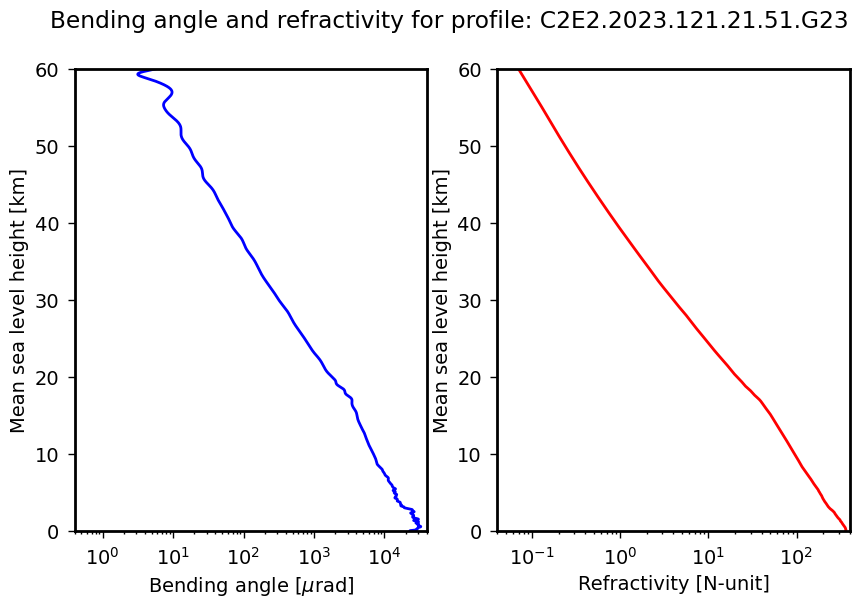

In [25]:
"""
Plot bending angle versus mean sea-level height,
now on a logarithmic scale.
"""
# Create the figure object with two columns and one row
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,6))
# Add the data to each subplot contained in 'axs'
axs[0].plot(bending_angle,mean_sea_level_height,color='b')
axs[1].plot(refractivity,mean_sea_level_height,color='r')
# Set the axis labels
axs[0].set_xlabel('Bending angle [$\mu$rad]')
axs[1].set_xlabel('Refractivity [N-unit]')
axs[0].set_ylabel('Mean sea level height [km]')
axs[1].set_ylabel('Mean sea level height [km]')
# Set axis limits (None means unbounded; Matplotlib will decide)
axs[0].set_xlim(0.4,40000)
axs[1].set_xlim(0.04,400)
axs[0].set_ylim(0,60)
axs[1].set_ylim(0,60)
# Set the x-axis to be logarithmic
axs[0].set_xscale('log')
axs[1].set_xscale('log')
# Set the title
fig.suptitle(f'Bending angle and refractivity for profile: {atmPrf_fname_short_now}')
# Generate the plot
plt.show()

In [ ]:
# Additional date variables
data_datetime = datetime.strptime(data_yrdoy,'%Y.%j')
data_yyyymmdd = datetime.strftime(data_datetime,'%Y-%m-%d')

Now let's further investigate the levels of the data in atmPrf. These data are not given on a uniform grid. The vertical levels between profiles are not the same, and the spacing between vertical levels within one profile is not the same.

To see this latter characteristic, let's calculate the vertical spacing of all levels and generate a simple histogram. For this, we'll use mean sea-level height.

In [33]:
"""
Statistics of the vertical spacing
"""
# Calculate the magnitude of the spacing in [m]
dz_levs = np.abs(mean_sea_level_height[1:]-mean_sea_level_height[:-1]) * 1.E3
# Calculate the statistics of the spacing
dz_levs_mean = np.mean(dz_levs)
dz_levs_stddev = np.std(dz_levs)

# Information
print(f'[INFO] Vertical spacing in [m] for atmPrf file: {atmPrf_fname_short_now}')
print(f'[INFO]     Mean     : {dz_levs_mean:7.2f}')
print(f'[INFO]     Std. Dev : {dz_levs_stddev:7.2f}')

[INFO] Vertical spacing in [m] for atmPrf file: atmPrf_C2E2.2023.121.21.51.G23_0001.0001_nc
[INFO]     Mean     :   20.59
[INFO]     Std. Dev :    1.63


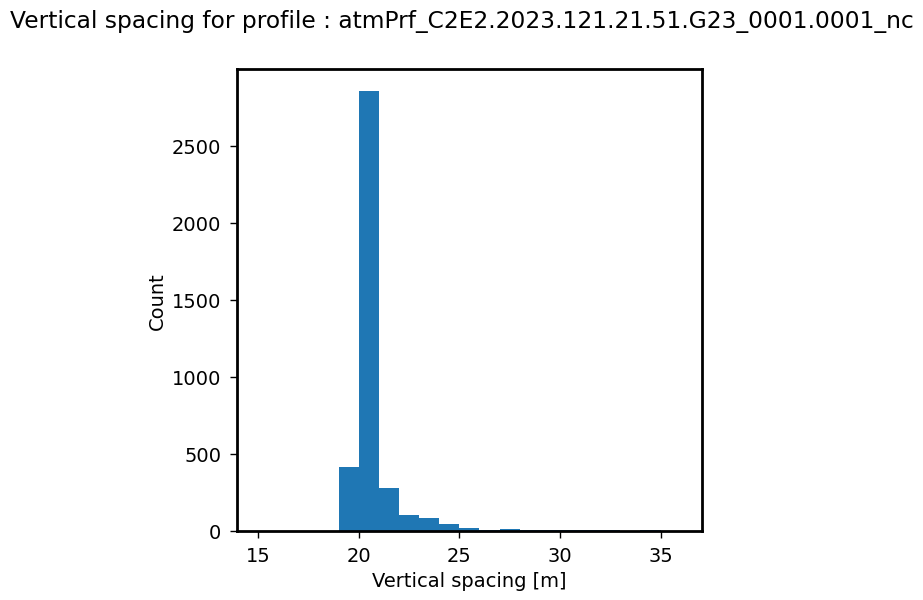

In [43]:
"""
Generate a histogram
Set the bins to span 15-35
"""
fig, axs = plt.subplots(1, 1, figsize=(6,6))
axs.hist(dz_levs, bins=np.arange(15,37,1.0))
axs.set_xlabel('Vertical spacing [m]')
axs.set_ylabel('Count')
fig.suptitle(f'Vertical spacing for profile : {atmPrf_fname_short_now}')
plt.show()